In [61]:
import logging
import time
import matplotlib.pyplot as plt
import cflib.crtp
import numpy as np

from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.utils import uri_helper
import cflib.crtp
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)

In [62]:
class FlipPlanner:
    def __init__(self, FLIP=1):
        if (FLIP==1):
            print("SINGLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 160
            self.Phi_g2 = 0
            self.Phi_g3 = 220
            self.omega_max = 1400
            self.asc_time = 0.23
            self.duration = 0.5
        if (FLIP==2):
            print("DOUBLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 200
            self.Phi_g2 = 300
            self.Phi_g3 = 220
            self.omega_max = 1600
            self.asc_time = 0.25
            self.duration = 0.75
        if (FLIP==3):
            print("TRIPLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 220
            self.Phi_g2 = 520
            self.Phi_g3 = 340
            self.omega_max = 2000
            self.asc_time = 0.3
            self.duration = 0.8 

    def calculateStages(self):
        # Stage 1
        self.gamma1 = self.Phi_g1/self.omega_max
        self.beta1 = -(3/4)*self.omega_max/self.gamma1**3
        self.omega_dot_max1 = (3/4)*self.omega_max**2/self.Phi_g1
        self.delta1 = 2*self.gamma1
        # Stage 2
        self.delta2 = self.Phi_g2/self.omega_max
        self.delta2n = -1.0
        # Stage 3
        self.gamma3 = self.Phi_g3/self.omega_max
        self.beta3 = -(3/4)*self.omega_max/self.gamma3**3
        self.omega_dot_max3 = (3/4)*self.omega_max**2/self.Phi_g3
        self.delta3 = 2*self.gamma3
        print("CALCULATED, RUN")

    def generateTraj2(self, t, phi_g):
        """ Generates reference angular rate trajectory 
        considering generalized flipping angle

        :param t: time since starting flipping
        :param phi_g: generalized flipping angle

        """
        omega_max = self.omega_max
        Phi_g1 = self.Phi_g1
        Phi_g2 = self.Phi_g2
        Phi_g3 = self.Phi_g3
        # Stage 1
        gamma1 = self.gamma1
        beta1 = self.beta1
        delta1 = self.delta1
        # Stage 2
        # Stage 3
        gamma3 = self.gamma3
        beta3 = self.beta3  
        delta2n = self.delta2n
        if phi_g <= Phi_g1:
            omega_d = beta1*(t - gamma1)**3/3 - beta1*gamma1**2*t + beta1*gamma1**3/3
            omega_dot_d = beta1*(t - gamma1)**2 - beta1*gamma1**2
            if t >= delta1:
                omega_d = omega_max
                omega_dot_d = 0
            
        if (phi_g > Phi_g1) and (phi_g <= (Phi_g1 + Phi_g2)):
            omega_d = omega_max
            omega_dot_d = 0

        if (phi_g > (Phi_g1 + Phi_g2)) and (phi_g <= (Phi_g1 + Phi_g2 + Phi_g3)):
            if delta2n == -1:
                self.delta2n = t # actual end time of stage 2
                delta2n = t

            omega_d = beta3*(gamma3 + delta2n - t)**3/3 - beta3*gamma3**2*(2*gamma3 + delta2n - t) + beta3*gamma3**3/3
            omega_dot_d = -beta3*(gamma3 + delta2n - t)**2 + beta3*gamma3**2
        if phi_g > (Phi_g1 + Phi_g2 + Phi_g3):
            omega_d = 0
            omega_dot_d = 0
        
        return omega_d

    def generateTraj1(self, t):
        """ Generates reference angular rate trajectory 
        w/o considering generalized flipping angle

        :param t: time since starting flipping

        """        
        omega_max = self.omega_max
        Phi_g1 = self.Phi_g1
        Phi_g2 = self.Phi_g2
        Phi_g3 = self.Phi_g3
        # Stage 1
        gamma1 = self.gamma1
        beta1 = self.beta1
        delta1 = self.delta1
        # Stage 2
        delta2 = self.delta2
        # Stage 3
        gamma3 = self.gamma3
        beta3 = self.beta3  
        delta3 = self.delta3

        if t <= delta1:
            omega_d = beta1*(t - gamma1)**3/3 - beta1*gamma1**2*t + beta1*gamma1**3/3
            omega_dot_d = beta1*(t - gamma1)**2 - beta1*gamma1**2
            if t >= delta1:
                omega_d = omega_max
                omega_dot_d = 0

        if (delta1 < t and t <= delta1 + delta2):
            omega_d = omega_max
            omega_dot_d = 0

        if (delta1 + delta2 < t and t <= delta1 + delta2 + delta3):
            delta2n = delta1 + delta2
            omega_d = beta3*(gamma3 + delta2n - t)**3/3 - beta3*gamma3**2*(2*gamma3 + delta2n - t) + beta3*gamma3**3/3
            omega_dot_d = -beta3*(gamma3 + delta2n - t)**2 + beta3*gamma3**2

        if t > delta1 + delta2 + delta3:
            omega_d = 0
            omega_dot_d = 0
            
        return omega_d

In [63]:
KK = np.array([[0, 0, -6e-01,
        0, 0, 0,
        0, 0, -5e-01,
        0, 0, 0],
       [0, -8.0e-04, 0,
        -4e-03, 0, 0,
        0, -1.1e-03, 0,
        -9.0e-04, 0, 0],
       [ 8.0e-04, 0, 0,
        0, -4e-03, 0,
         1.1e-03, 0, 0,
        0, -9.0e-04, 0],
       [0, 0, 0,
        0, 0, -1.4e-02,
        0, 0, 0,
        0, 0, -1.0e-02]])

In [144]:
### ROLL FLIP ###
log_keys = ['controller.rollRate','stateEstimateZ.rateRoll','stateEstimate.roll']
# log_keys = ['stateEstimateZ.x', 'stateEstimateZ.y', 'stateEstimateZ.z']

lg_stab = LogConfig(name='flip', period_in_ms=10)
lg_data = {}
for key in log_keys:
    lg_stab.add_variable( key, 'float')
    lg_data[key.split('.')[1]] = []

URI = uri_helper.uri_from_env(default='radio://0/80/2M/E7E7E7E7E7')

flip_rate = 0.0
flip_angle = []

if __name__ == '__main__':
    # Initialize the low-level drivers
    planner = FlipPlanner(FLIP=1)
    planner.calculateStages()

    cflib.crtp.init_drivers(enable_debug_driver=False)
    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf
        h = 0.9   # stabilization height TODO: for each case
        for i in range(4):
            for j in range(12):
                cf.param.set_value(f'ctrlLQR.k{i + 1}{j + 1}', '{:.10f}'.format(KK[i, j]))

        # print('Initializing as PID')
        cf.param.set_value('stabilizer.controller', '1')
        cf.param.set_value('posCtlPid.zKp', '3.0')
        cf.param.set_value('pid_attitude.roll_kp', '7.0')
        cf.param.set_value('pid_attitude.pitch_kp', '7.0')
        # cf.param.set_value('pid_attitude.roll_kd', '0.1')
        # cf.param.set_value('pid_attitude.pitch_kd', '0.1')

        cf.param.set_value('kalman.resetEstimation', '1')
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)

        # print('Reset Kalman filter.')
        print('Taking off!')
        cf.commander.send_setpoint(0, 0, 0, 0)

        # drone take off to a height
        for y in range(10):        
            cf.commander.send_hover_setpoint(0, 0, 0, h*y/10)
            time.sleep(0.1)

        for _ in range(50):
            cf.commander.send_hover_setpoint(0, 0, 0, h)
            time.sleep(0.1)


        # execute trajectory
        # step 1: ascend
        print('Ascending!')
        asc_time = planner.asc_time
        asc_thrust = 60000  # max thrust
        t_start = time.time()
        while True:
            t_current = time.time()
            t = abs(t_current-t_start)  # time since starting flipping
            if t > asc_time:
                break
            # cf.commander.send_setpoint(0, 0, 0, asc_thrust)
            cf.commander.send_hover_setpoint(0, 0, 0, 6*h)

        # step 2: flip (tracking desired angular rate)
        print('Flipping!')
        # cf.param.set_value('stabilizer.controller', '1')
        cf.param.set_value('flightmode.stabModeRoll', '0')    # to rate mode
        cf.param.set_value('stabilizer.tumbleCheckEn', '0')    # disable tumble check
        cf.param.set_value('pid_rate.roll_kp', '450')
        cf.param.set_value('pid_rate.roll_ki', '50')
        cf.param.set_value('pid_rate.roll_kd', '15')

        waypoints = []
        time_list = []
        # TODO: take flipping angle to switch trajectory
        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()
            t_current = time.time()
            t = abs(t_current-t_start)  # time since starting flipping
            flip_thrust = 40000
            t_prev = t_current
            for log_entry in logger:
                t_current = time.time()
                t = abs(t_current-t_start) 

                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)   

                delta_t = t_current - t_prev 
                t_prev = t_current
                flip_rate = lg_data['rateRoll'][-1]*180/3.14/1000 
                if len(flip_angle) == 0:
                    flip_angle.append(lg_data['roll'][-1])
                else:
                    flip_angle.append(flip_angle[-1]+flip_rate*delta_t)

                w = 1*planner.generateTraj2(t, flip_angle[-1]+105)
                waypoints.append(w)
                time_list.append(t)
                cf.commander.send_setpoint(w,0,0,flip_thrust)

                if flip_angle[-1] > 345 or t > 0.6:
                    break   
        
        # step 3: stabilize
        # at a height
        print('Stabilizing!')
        cf.param.set_value('pid_rate.roll_kp', '250.0')
        cf.param.set_value('pid_rate.roll_ki', '500.0')
        cf.param.set_value('pid_rate.roll_kd', '2.50')
        cf.param.set_value('flightmode.stabModeRoll', '1')    # to angle mode
        # cf.param.set_value('stabilizer.controller', '2')
        cf.param.set_value('stabilizer.tumbleCheckEn', '1')    # enable tumble check
        h = 3
        for _ in range(1):
            cf.commander.send_hover_setpoint(0, 0, 0, h)
            time.sleep(0.05)
        h = 0.5           
        for _ in range(40):
            cf.commander.send_hover_setpoint(0, 0, 0, h)
            time.sleep(0.1)

        # drone landing
        print("Landing!")
        for y in range(10):
            cf.commander.send_hover_setpoint(0, 0, 0, (10 - y)*h / 10)
            time.sleep(0.1)

        cf.commander.send_stop_setpoint()

        # print(waypoints)
        # print(time_list)

SINGLE FLIP, PLEASE CALCULATE
CALCULATED, RUN
Taking off!
Ascending!
Flipping!
Stabilizing!
Landing!


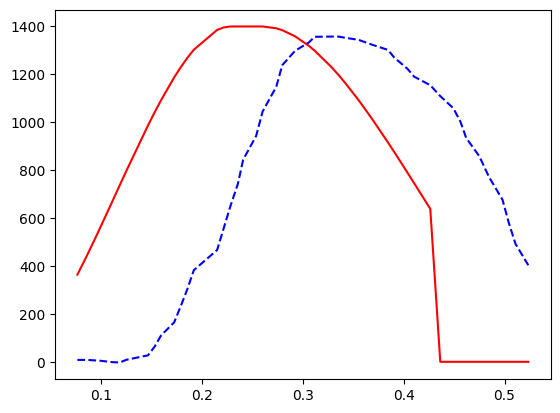

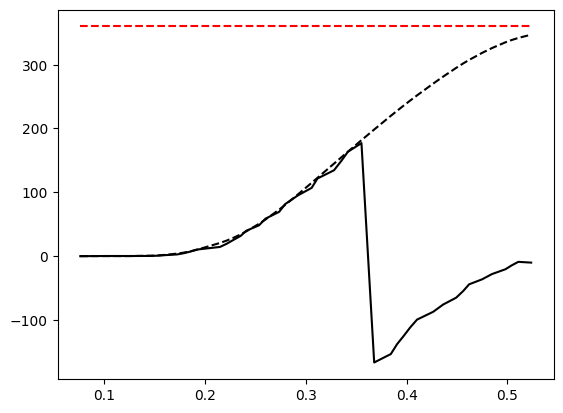

In [143]:
### PLOTS ###
plt.plot(time_list,waypoints,'r',time_list, np.array(lg_data['rateRoll'])*180/3.14/1000,'b--')
# plt.plot(time_list, np.array(lg_data['roll'])*10,'k',time_list,waypoints,'y', time_list, lg_data['rollRate'],'r',time_list, np.array(lg_data['rateRoll'])*180/3.14/1000,'b--')

# plt.figure()
# plt.plot(,time_list, lg_data['rollRate'],'b--')
plt.figure()
plt.plot(time_list, lg_data['roll'], 'k', time_list, flip_angle, 'k--', time_list, 360*np.ones(len(time_list)), 'r--')


In [ ]:
planner = FlipPlanner(FLIP=1)
planner.calculateStages()
# planner.delta2n=-1
t = 0.3
print(planner.generateTraj2(t, 182))

omega_d = planner.beta3*(planner.gamma3 + planner.delta2n - t)**3/3 - planner.beta3*planner.gamma3**2*(2*planner.gamma3 + planner.delta2n - t) + planner.beta3*planner.gamma3**3/3
print(omega_d)

# for k in range(15,len(time_list)):
#     print(flip_angle[k])
#     print(planner.generateTraj2(time_list[k], flip_angle[k]))
    
    